In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
class clustering_pipeline:
    def __init__(self, vectorizer, n_components, reducer):
        self.vectorizer = vectorizer
        self.n_dim = n_components
        self.reducer = reducer(n_components)
        
    def fit(self, text):
        self.vectorizer.fit(text)
        self.vector_data = self.vectorizer.fit_transform(text)
        self.topic_data = self.reducer.fit_transform(self.vector_data)
        self.texts = text

    def tsne(self, n_components, perplexity):
        tsne = TSNE(n_components = n_components, perplexity = perplexity)
        plt.figure(dpi=300)
        vector_tsne = tsne.fit_transform(self.topic_data)
        sns.scatterplot(vector_tsne[:, 0], vector_tsne[:, 1],hue=self.labels_, alpha=0.5, size = 0.5, 
                        palette='rainbow', legend='full')
        plt.title(f'tSNE on topic space using {self.cluster_method}');
        plt.figure(dpi=300)
        plt.hist(self.labels_, bins=self.n_clusters);
        
    def kmeans(self, n_clusters):
        self.km = KMeans(n_clusters=n_clusters)
        self.labels_ = self.km.fit_predict(self.vector_data)
        self.cluster_method='kmeans'
        self.n_clusters=n_clusters
        
    def db(self, eps, min_samples):
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(self.x)
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        self.labels_ = db.labels_
        self.cluster_method='db'
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        self.n_clusters=n_clusters

    def spectral(self, article, num_to_return, n_clusters):
        sc = SpectralClustering(n_clusters=n_clusters)
        self.labels_ = sc.fit_predict(self.x)
        self.cluster_method='spectral'
        self.n_clusters=n_clusters
        
    def meanshift(self, quantile, n_samples):
        bandwidth = estimate_bandwidth(self.x, quantile=quantile, n_samples=n_samples)
        ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
        ms.fit(self.x)
        self.labels_ = ms.labels_
        self.cluster_method = 'meanshift'
        cluster_centers = ms.cluster_centers_

        labels_unique = np.unique(self.labels_)
        self.n_clusters_ = len(labels_unique)

        print("number of estimated clusters : %d" % n_clusters_)

        result_texts = [self.texts[i] for i in results[1][0]]
        
        return result_texts

In [3]:
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / np.sqrt(np.dot(vec1, vec1) * np.dot(vec2, vec2))

def find_cluster_closest_cosine_verses(cluster):
    overall_clusters=[]
    for number in set(cluster.labels_):
        cluster_center = cluster.km.cluster_centers_[number]
        distances=[]
    for index, vector in enumerate(cluster.topic_data):
        dist = cosine_similarity(cluster_center,vector)
        distances.append((dist, index))
    distances.sort()
    indices=[x[1] for x in distances[-4:]]
    print(distances[-4:])
    for i in indices:
        print(df.review.iloc[i])

In [4]:
df = pd.read_pickle('cleaned_df.pkl')
df.head()

,Age,ReviewText,Rating,RecommendedIND,PositiveFeedbackCount,DivisionName,DepartmentName,ClassName,CombinedText
0,33,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,Absolutely wonderful - silky and sexy and com...
1,34,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,Love this dress! it's sooo pretty. i happen...
2,60,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,Some major design flaws I had such high hopes ...
3,50,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,"My favorite buy! I love, love, love this jumps..."
4,47,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,Flattering shirt This shirt is very flattering...


In [5]:
count_vectorizer = CountVectorizer(ngram_range=(1, 2),  
                                   stop_words='english', 
                                   token_pattern="\\b[a-z][a-z]+\\b",
                                   lowercase=True,
                                   max_df = 0.6)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),  
                                   stop_words='english', 
                                   token_pattern="\\b[a-z][a-z]+\\b",
                                   lowercase=True,
                                   max_df = 0.6)

cv_data = count_vectorizer.fit_transform(df.ReviewText)
tfidf_data = tfidf_vectorizer.fit_transform(df.ReviewText)

In [6]:
n_comp = 30
lsa_tfidf = TruncatedSVD(n_components=n_comp)
lsa_cv = TruncatedSVD(n_components=n_comp)
nmf_tfidf = NMF(n_components=n_comp)
nmf_cv = NMF(n_components=n_comp)

lsa_tfidf_data = lsa_tfidf.fit_transform(tfidf_data)
lsa_cv_data = lsa_cv.fit_transform(cv_data)
nmf_tfidf_data = nmf_tfidf.fit_transform(tfidf_data)
nmf_cv_data = nmf_cv.fit_transform(cv_data)

# lsa_tfidf

In [7]:
SSEs = []
Sil_coefs = []
for k in range(2,10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(lsa_tfidf_data)
    labels = km.labels_
    Sil_coefs.append(silhouette_score(lsa_tfidf_data, labels, metric='euclidean'))
    SSEs.append(km.inertia_) 

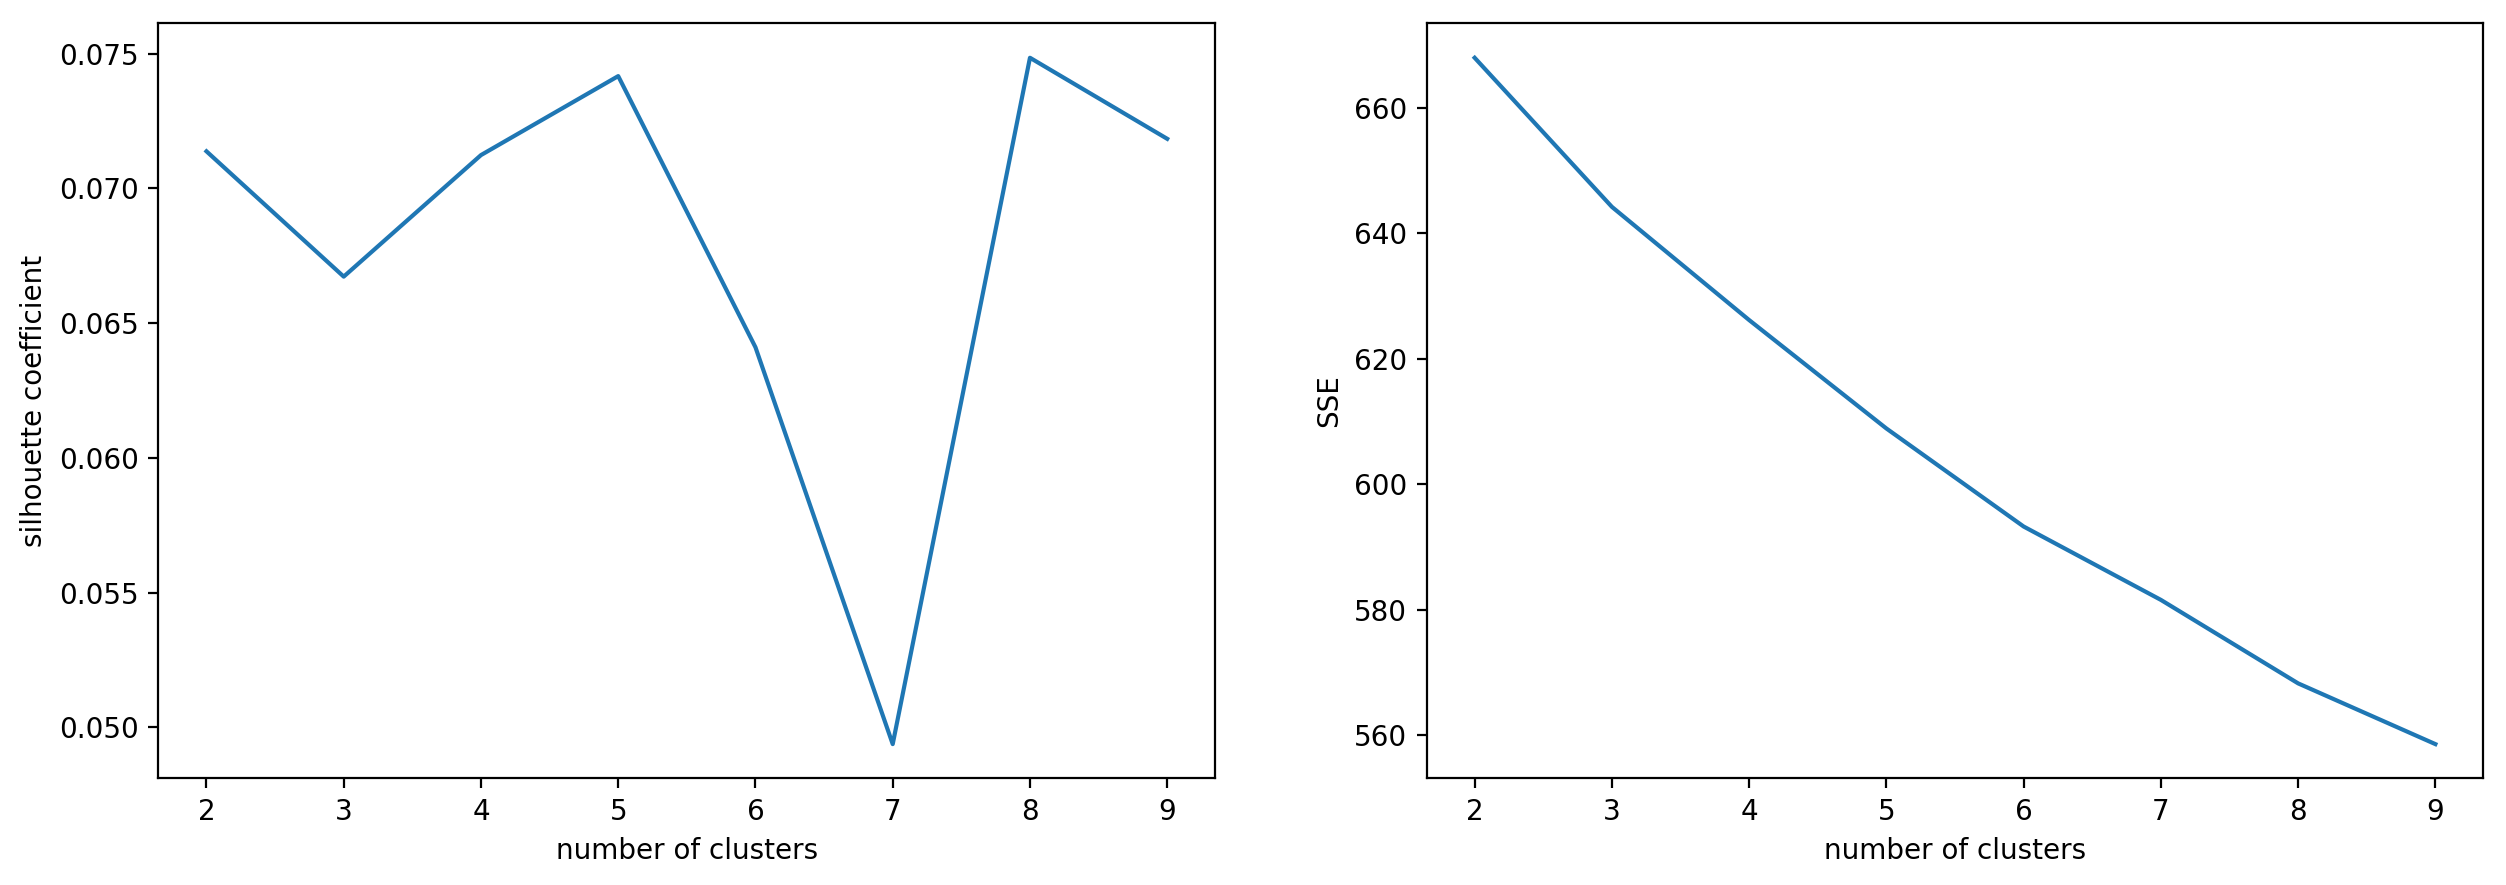

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True, dpi=200)
k_clusters = range(2,10)
ax1.plot(k_clusters, Sil_coefs)
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette coefficient')

# plot here on ax2
ax2.plot(k_clusters, SSEs)
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('SSE');

In [9]:
inertia = [0,0]

for n_clusters in range(2, 25):
    km = KMeans(n_clusters = n_clusters)
    km.fit(lsa_tfidf_data)
    msg = f"""# clusters: {n_clusters:2d}   Inertia: {km.inertia_:8.6f}"""
    inertia.append(km.inertia_)
    print(msg)

# clusters:  2   Inertia: 667.974643
# clusters:  3   Inertia: 644.216266
# clusters:  4   Inertia: 626.466233
# clusters:  5   Inertia: 609.734215
# clusters:  6   Inertia: 593.285852
# clusters:  7   Inertia: 582.104841
# clusters:  8   Inertia: 568.960448
# clusters:  9   Inertia: 557.812326
# clusters: 10   Inertia: 548.729287
# clusters: 11   Inertia: 538.847174
# clusters: 12   Inertia: 529.752551
# clusters: 13   Inertia: 521.708644
# clusters: 14   Inertia: 514.373608
# clusters: 15   Inertia: 508.114657
# clusters: 16   Inertia: 500.520617
# clusters: 17   Inertia: 496.137932
# clusters: 18   Inertia: 490.825047
# clusters: 19   Inertia: 484.511485
# clusters: 20   Inertia: 480.858134
# clusters: 21   Inertia: 476.529373
# clusters: 22   Inertia: 472.971176
# clusters: 23   Inertia: 468.782500
# clusters: 24   Inertia: 467.033441


(900, 1500)

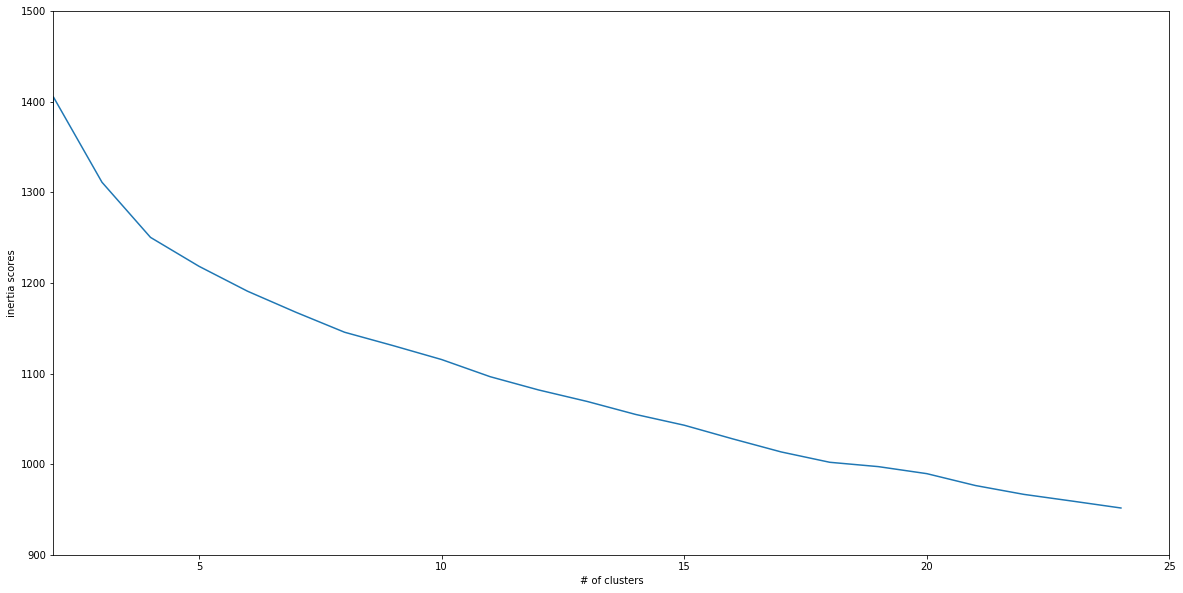

In [30]:
plt.figure(figsize=(20,10))
plt.plot(inertia)
plt.xlabel('# of clusters')
plt.xlim((2,25))
plt.ylabel('inertia scores')
plt.ylim((900,1500))

# lsa_cv

In [11]:
SSEs = []
Sil_coefs = []
for k in range(2,10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(lsa_cv_data)
    labels = km.labels_
    Sil_coefs.append(silhouette_score(lsa_cv_data, labels, metric='euclidean'))
    SSEs.append(km.inertia_) 

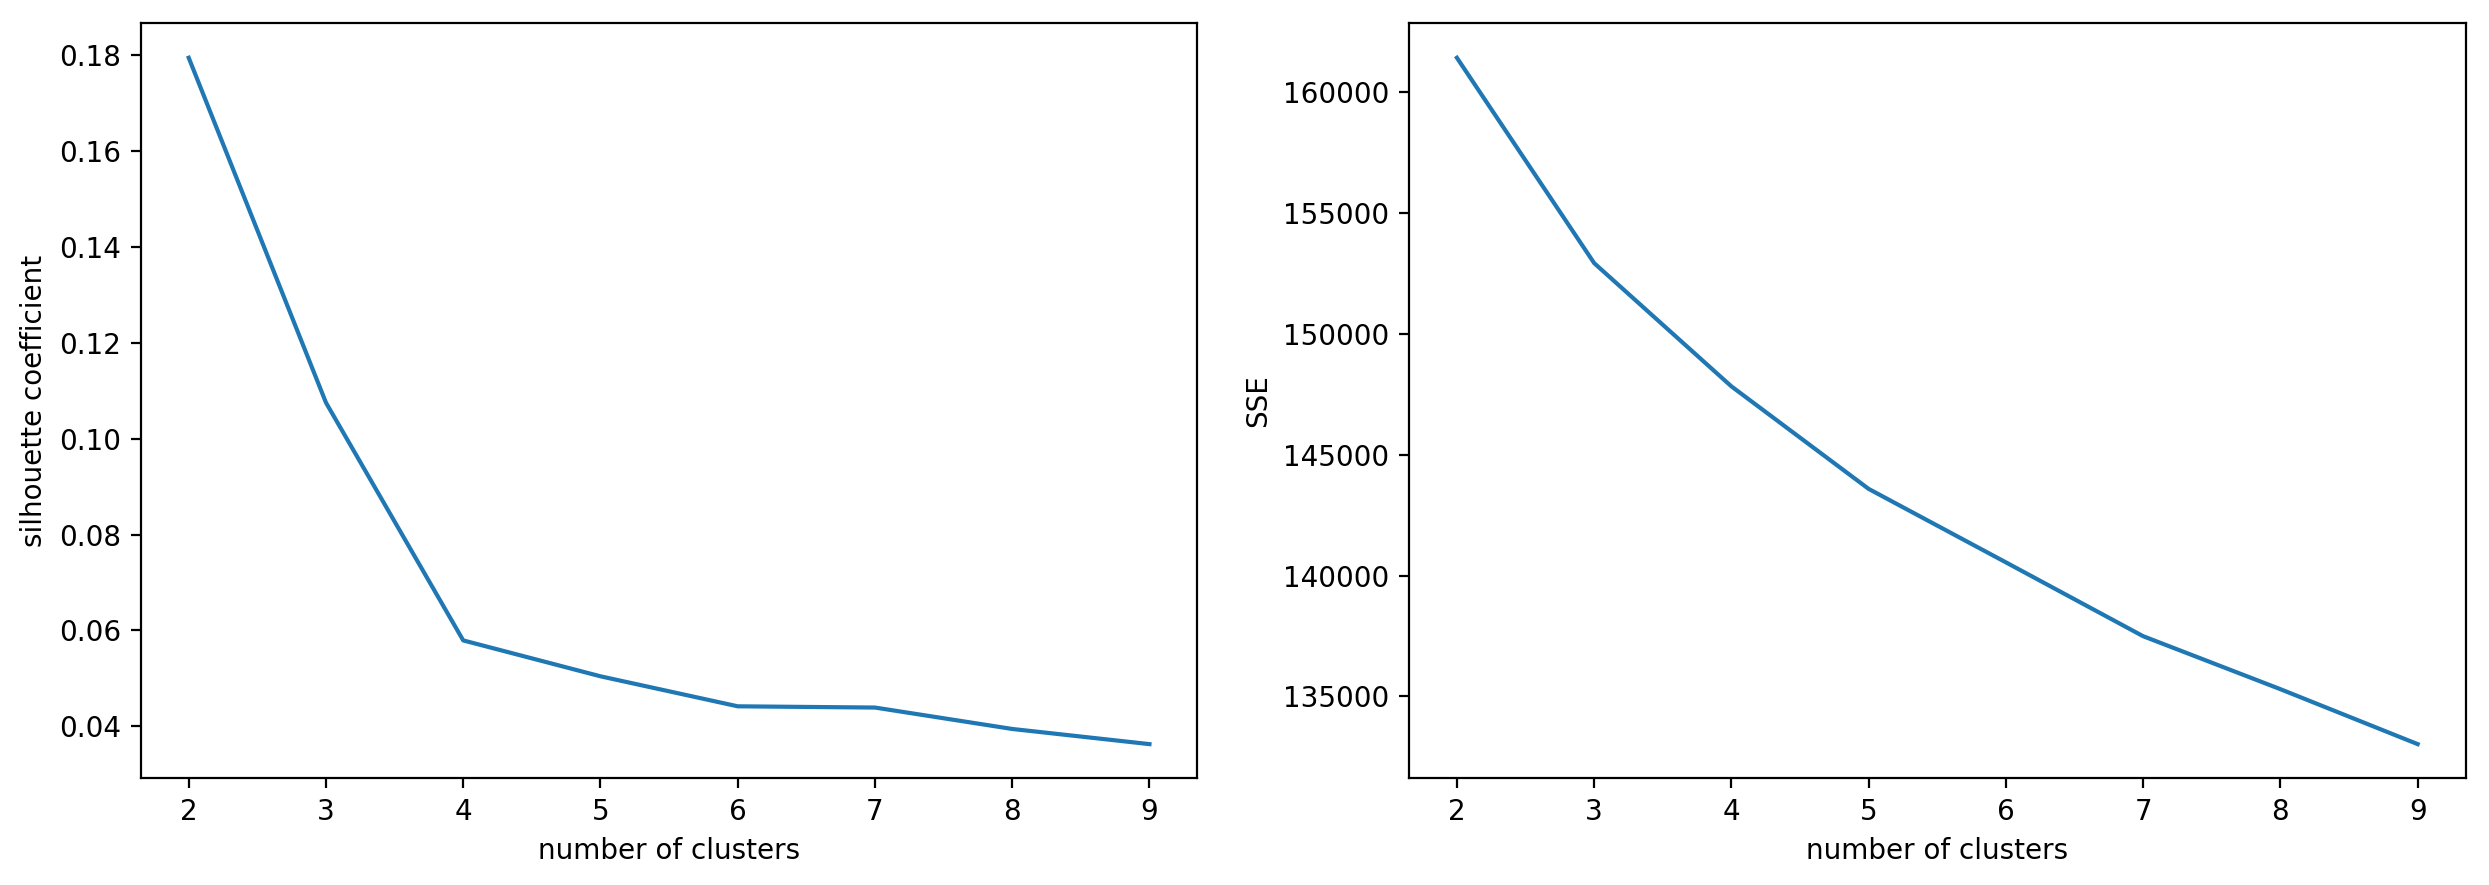

In [12]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True, dpi=200)
k_clusters = range(2,10)
ax1.plot(k_clusters, Sil_coefs)
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette coefficient')

# plot here on ax2
ax2.plot(k_clusters, SSEs)
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('SSE');

In [13]:
inertia = [0,0]

for n_clusters in range(2, 25):
    km = KMeans(n_clusters = n_clusters)
    km.fit(lsa_cv_data)
    msg = f"""# clusters: {n_clusters:2d}   Inertia: {km.inertia_:8.6f}"""
    inertia.append(km.inertia_)
    print(msg)

# clusters:  2   Inertia: 161434.793885
# clusters:  3   Inertia: 152933.587908
# clusters:  4   Inertia: 147835.319951
# clusters:  5   Inertia: 143586.075991
# clusters:  6   Inertia: 140370.770465
# clusters:  7   Inertia: 137702.692770
# clusters:  8   Inertia: 135421.652455
# clusters:  9   Inertia: 133064.575846
# clusters: 10   Inertia: 131932.799066
# clusters: 11   Inertia: 130042.133069
# clusters: 12   Inertia: 128220.493148
# clusters: 13   Inertia: 126582.284456
# clusters: 14   Inertia: 124784.551659
# clusters: 15   Inertia: 123940.040370
# clusters: 16   Inertia: 122311.012381
# clusters: 17   Inertia: 121301.802329
# clusters: 18   Inertia: 120027.651378
# clusters: 19   Inertia: 119433.059632
# clusters: 20   Inertia: 118051.386781
# clusters: 21   Inertia: 117336.376761
# clusters: 22   Inertia: 116861.666981
# clusters: 23   Inertia: 115288.746146
# clusters: 24   Inertia: 114801.617175


(900, 1500)

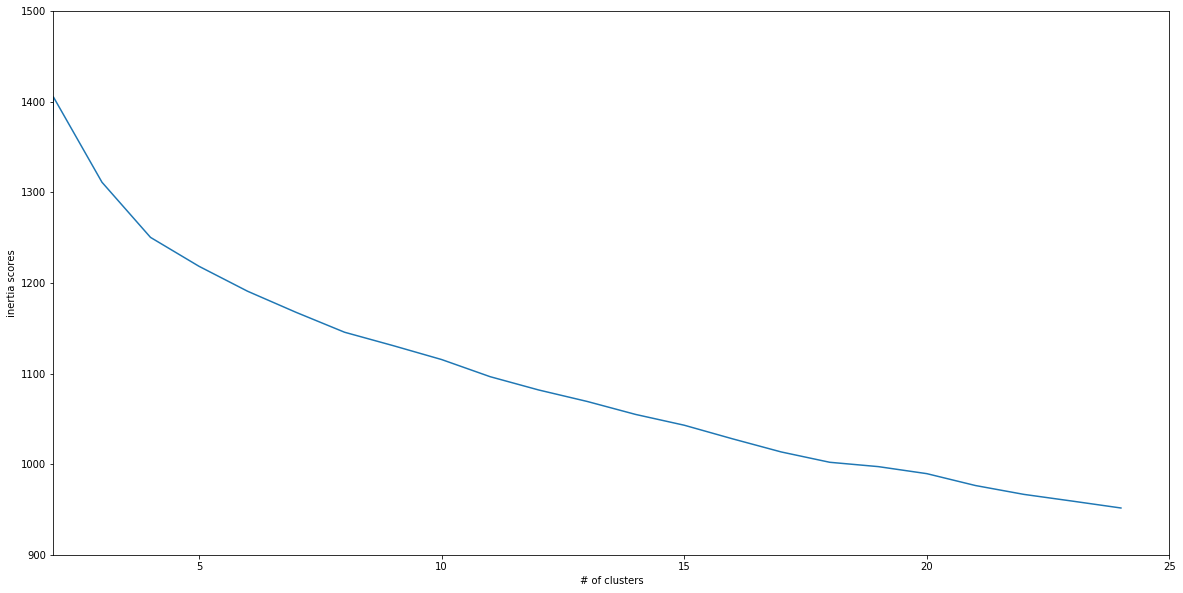

In [28]:
plt.figure(figsize=(20,10))
plt.plot(inertia)
plt.xlabel('# of clusters')
plt.xlim((2,25))
plt.ylabel('inertia scores')
plt.ylim((900,1500))

# nmf_tfidf

In [15]:
SSEs = []
Sil_coefs = []
for k in range(2,10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(nmf_tfidf_data)
    labels = km.labels_
    Sil_coefs.append(silhouette_score(nmf_tfidf_data, labels, metric='euclidean'))
    SSEs.append(km.inertia_) 

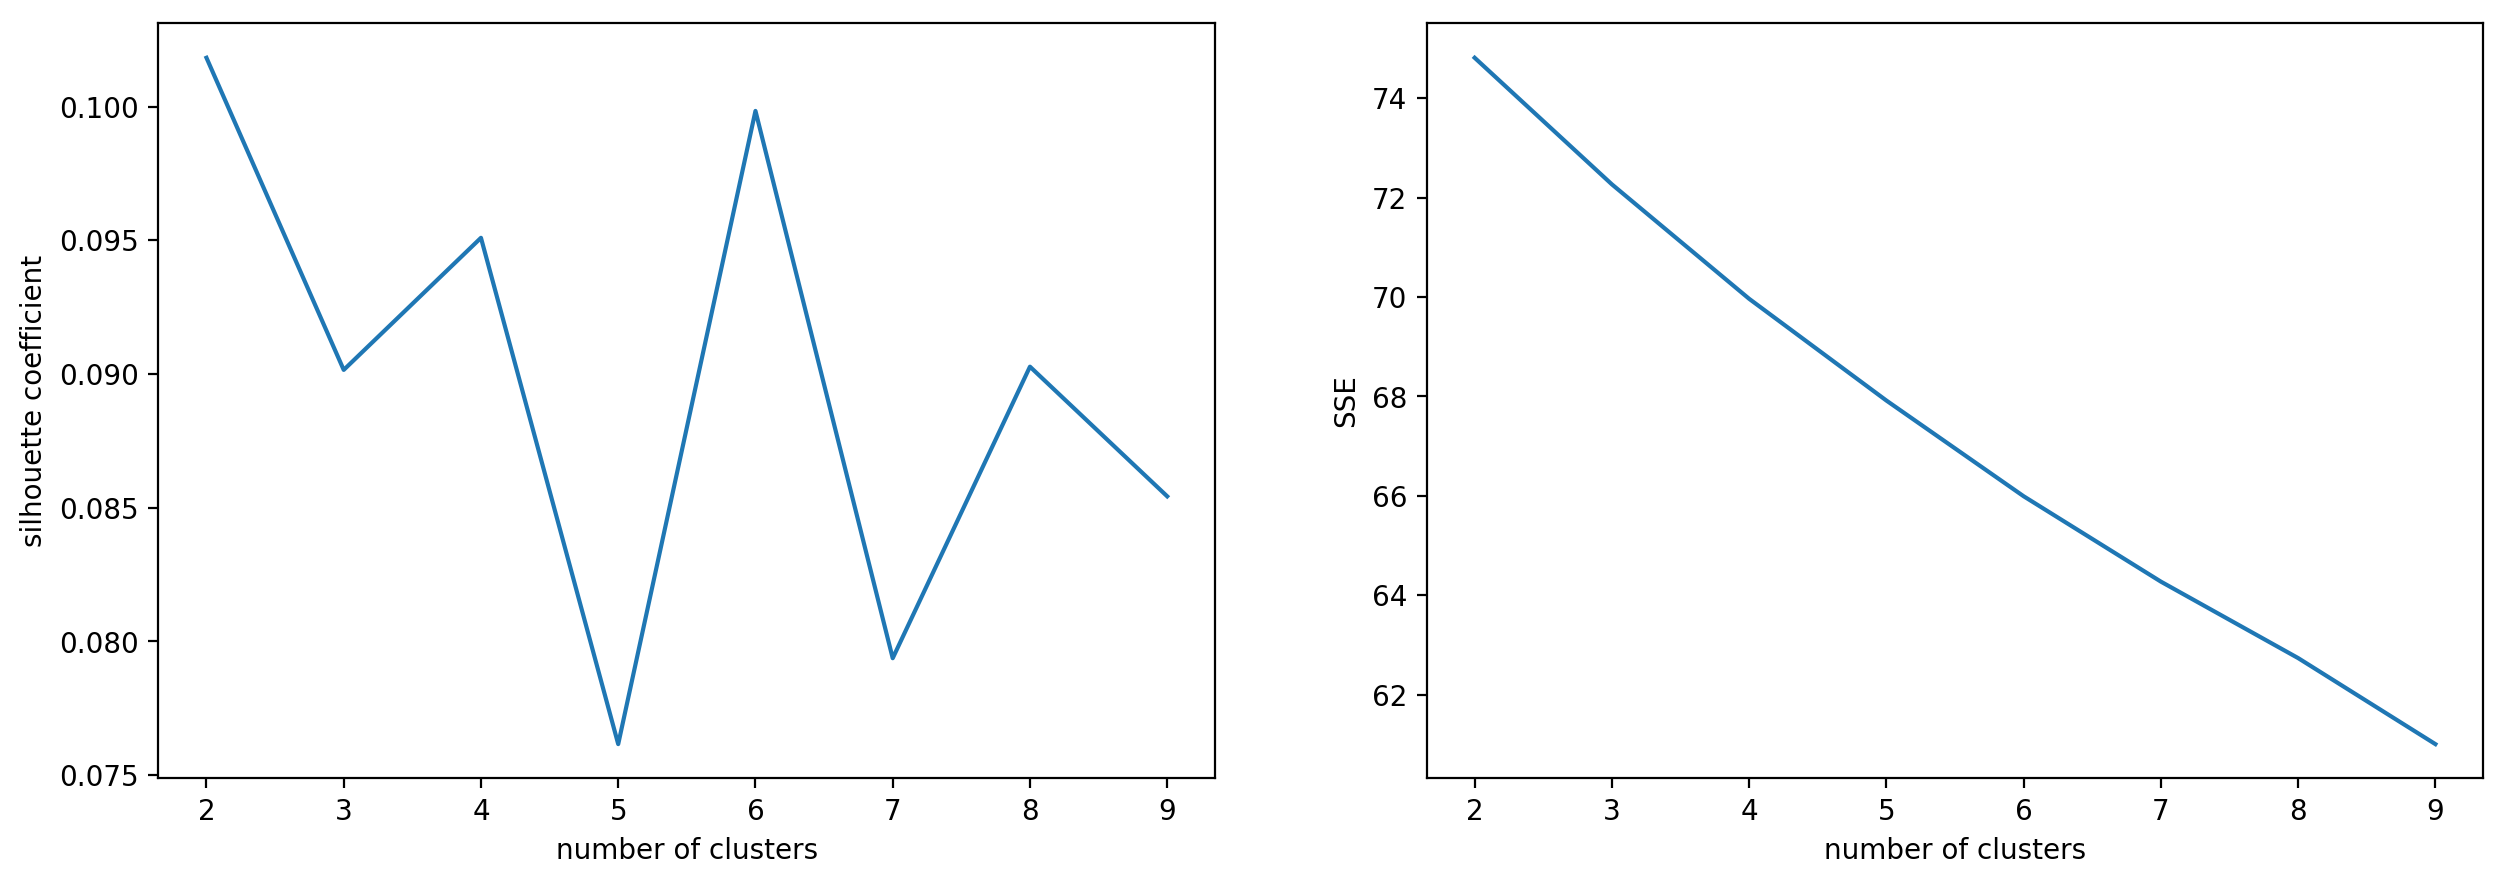

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True, dpi=200)
k_clusters = range(2,10)
ax1.plot(k_clusters, Sil_coefs)
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette coefficient')

# plot here on ax2
ax2.plot(k_clusters, SSEs)
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('SSE');

In [17]:
inertia = [0,0]

for n_clusters in range(2, 25):
    km = KMeans(n_clusters = n_clusters)
    km.fit(nmf_tfidf_data)
    msg = f"""# clusters: {n_clusters:2d}   Inertia: {km.inertia_:8.6f}"""
    inertia.append(km.inertia_)
    print(msg)

# clusters:  2   Inertia: 74.813627
# clusters:  3   Inertia: 72.243833
# clusters:  4   Inertia: 69.964455
# clusters:  5   Inertia: 67.925959
# clusters:  6   Inertia: 65.968863
# clusters:  7   Inertia: 64.304134
# clusters:  8   Inertia: 63.029384
# clusters:  9   Inertia: 61.202113
# clusters: 10   Inertia: 59.849933
# clusters: 11   Inertia: 58.561898
# clusters: 12   Inertia: 56.931303
# clusters: 13   Inertia: 55.773503
# clusters: 14   Inertia: 54.842011
# clusters: 15   Inertia: 53.423371
# clusters: 16   Inertia: 52.543285
# clusters: 17   Inertia: 51.728801
# clusters: 18   Inertia: 50.905040
# clusters: 19   Inertia: 50.275182
# clusters: 20   Inertia: 49.618071
# clusters: 21   Inertia: 48.884516
# clusters: 22   Inertia: 48.424286
# clusters: 23   Inertia: 47.824550
# clusters: 24   Inertia: 47.592971


(900, 1500)

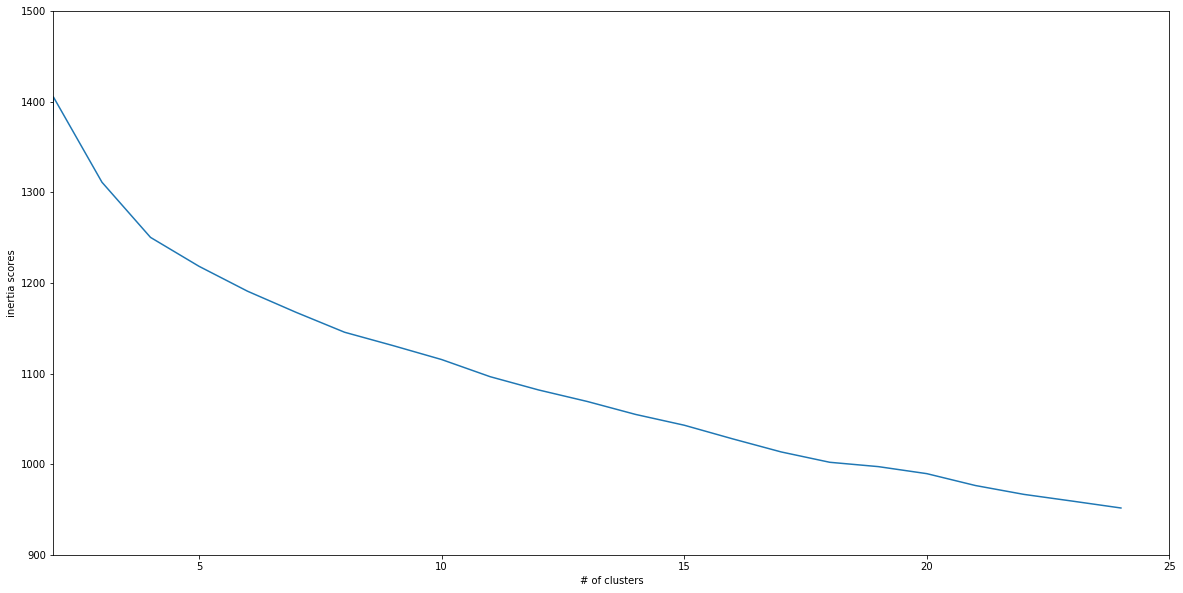

In [26]:
plt.figure(figsize=(20,10))
plt.plot(inertia)
plt.xlabel('# of clusters')
plt.xlim((2,25))
plt.ylabel('inertia scores')
plt.ylim((900,1500))

# nmf_cv

In [19]:
SSEs = []
Sil_coefs = []
for k in range(2,10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(nmf_cv_data)
    labels = km.labels_
    Sil_coefs.append(silhouette_score(nmf_cv_data, labels, metric='euclidean'))
    SSEs.append(km.inertia_) 

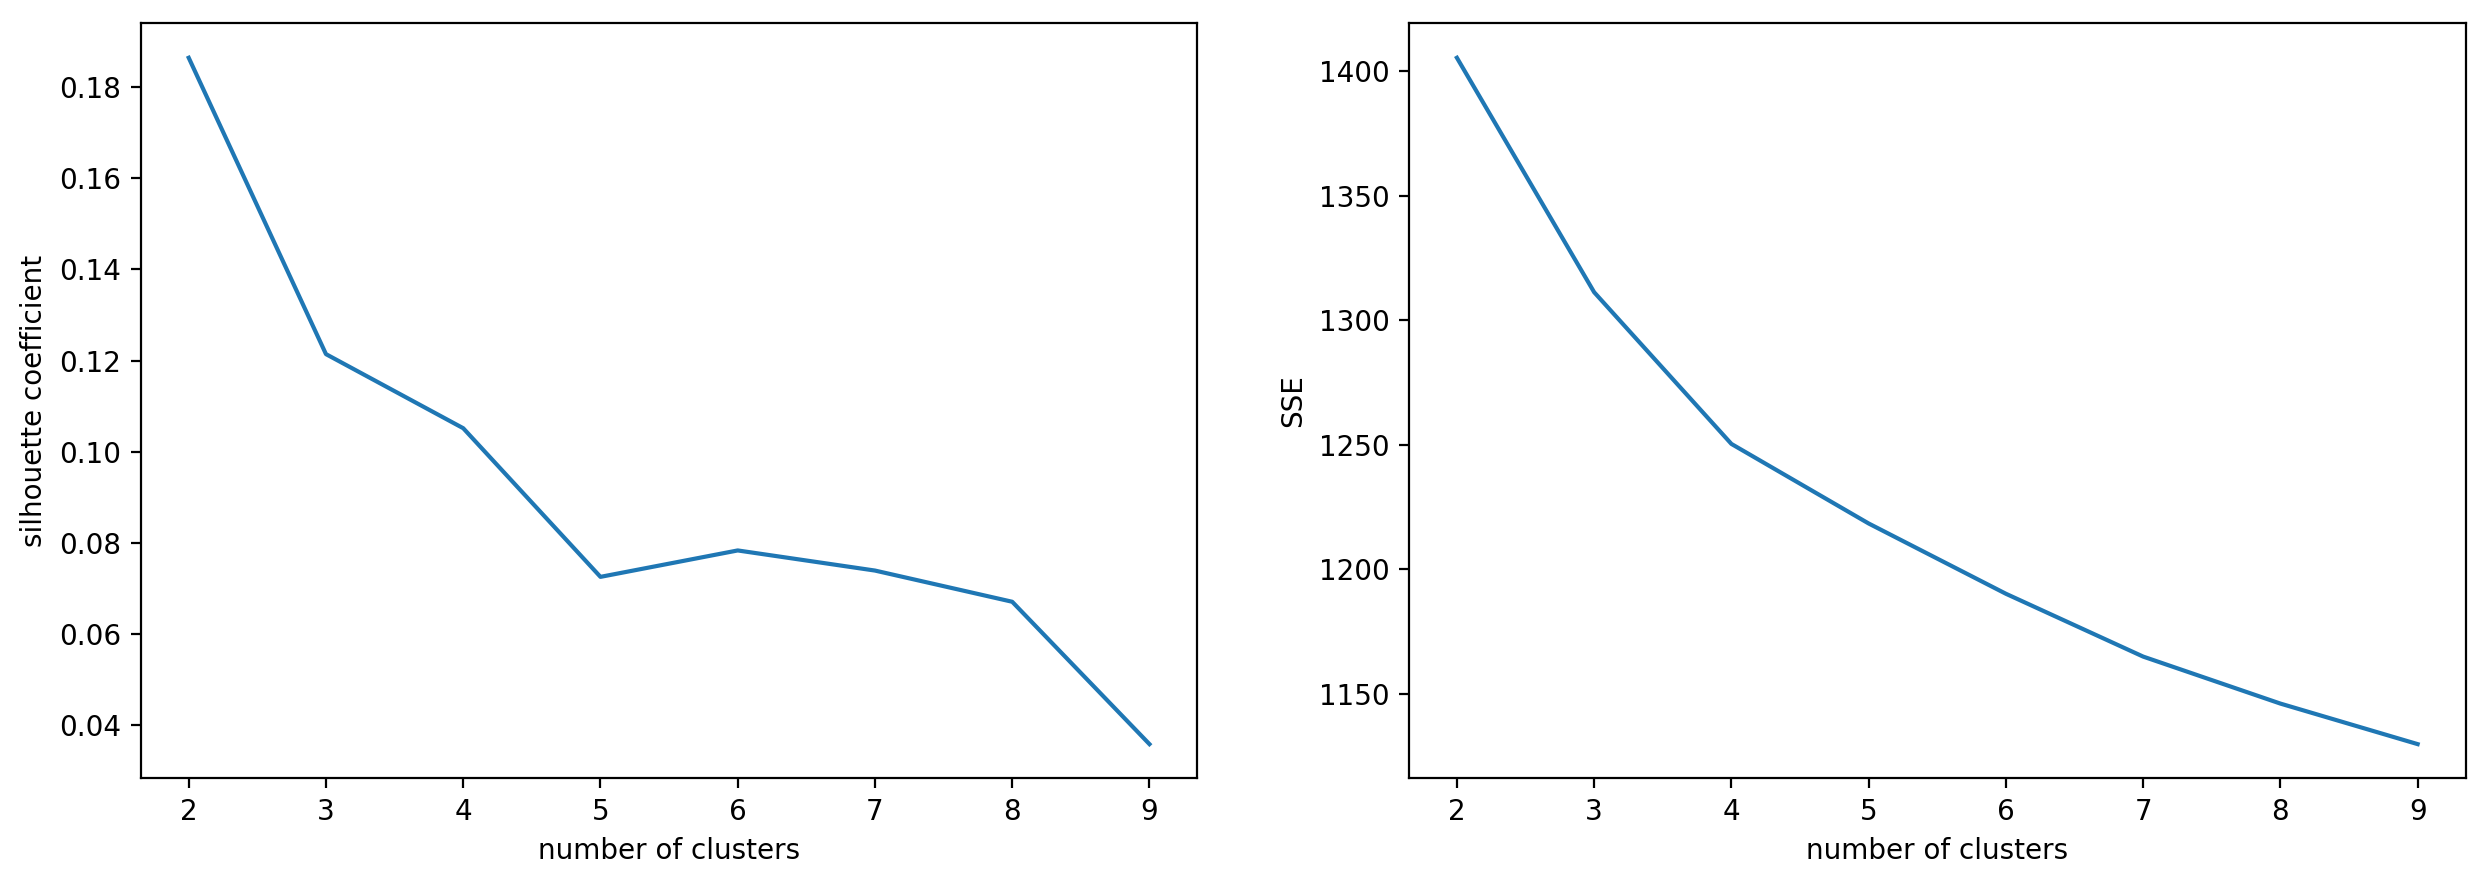

In [20]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True, dpi=200)
k_clusters = range(2,10)
ax1.plot(k_clusters, Sil_coefs)
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette coefficient')

# plot here on ax2
ax2.plot(k_clusters, SSEs)
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('SSE');

In [21]:
inertia = [0,0]

for n_clusters in range(2, 25):
    km = KMeans(n_clusters = n_clusters)
    km.fit(nmf_cv_data)
    msg = f"""# clusters: {n_clusters:2d}   Inertia: {km.inertia_:8.6f}"""
    inertia.append(km.inertia_)
    print(msg)

# clusters:  2   Inertia: 1405.288287
# clusters:  3   Inertia: 1311.214275
# clusters:  4   Inertia: 1250.353632
# clusters:  5   Inertia: 1218.429644
# clusters:  6   Inertia: 1190.926449
# clusters:  7   Inertia: 1167.627154
# clusters:  8   Inertia: 1145.646932
# clusters:  9   Inertia: 1130.879876
# clusters: 10   Inertia: 1115.513026
# clusters: 11   Inertia: 1096.589006
# clusters: 12   Inertia: 1081.927697
# clusters: 13   Inertia: 1069.251530
# clusters: 14   Inertia: 1054.904788
# clusters: 15   Inertia: 1043.023605
# clusters: 16   Inertia: 1027.934287
# clusters: 17   Inertia: 1013.505933
# clusters: 18   Inertia: 1002.109933
# clusters: 19   Inertia: 997.322325
# clusters: 20   Inertia: 989.558264
# clusters: 21   Inertia: 976.478799
# clusters: 22   Inertia: 966.687423
# clusters: 23   Inertia: 959.255899
# clusters: 24   Inertia: 951.660758


(900, 1500)

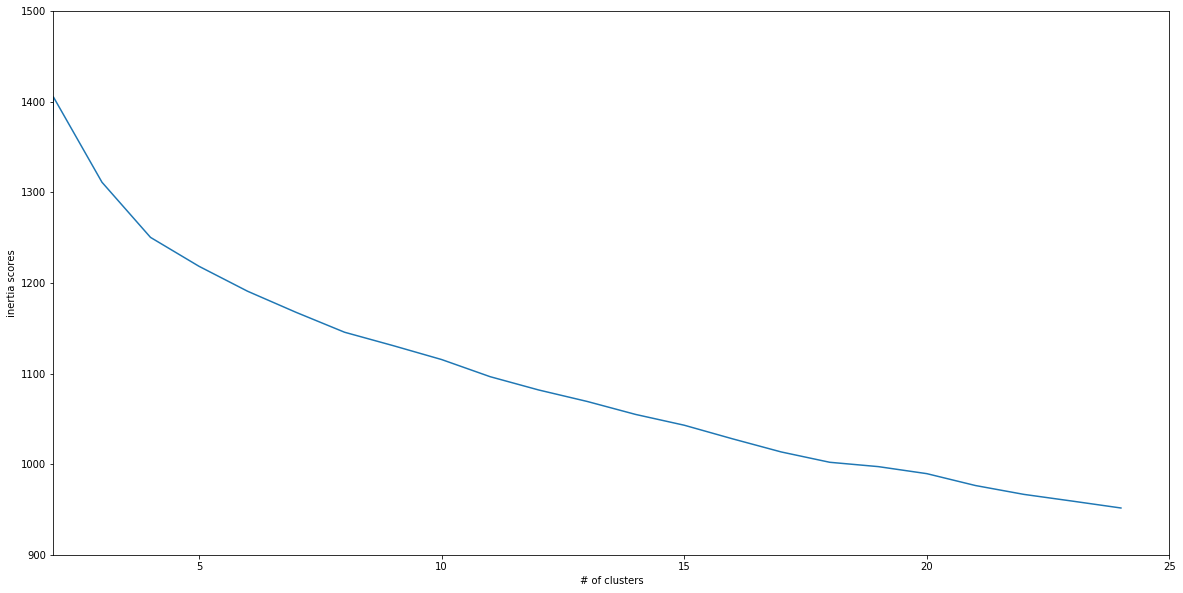

In [24]:
plt.figure(figsize=(20,10))
plt.plot(inertia)
plt.xlabel('# of clusters')
plt.xlim((2,25))
plt.ylabel('inertia scores')
plt.ylim((900,1500))